# 4. 모델 훈련

모델이 실제로 어떻게 작동하는지 이해하고 있으면 적절한 모델, 올바른 훈련 알고리즘, 적절한 하이퍼파라미터를 찾는데 도움이 됨.

이 장에서는 선형회귀, 다항회귀, 로지스틱회귀와 소프트맥스 회귀를 살펴봄으로써 신경망을 이해하고 구축하는데 도움이 되도록 할 것임.

## 4.1 선형회귀

선형회귀 모델은 정규방정식을 사용하거나 경사하강법을 사용하여 모델을 훈련시킴.

### 4.1.1 정규방정식

비용 함수를 최소화하는 θ값을 찾기 위한 해석적인 방법(수학 공식)을 정규방정식이라고 함.

In [1]:
import numpy as np
X = 2 * np.random.rand(100,1) # 0~1의 균등 분포에서 난수를 뽑아내어 (100,1) matrix 생성
y = 4 + 3 * X + np.random.randn(100,1) # 가우시안분포(표준정규분포)에서 난수를 뽑아내어 (100,1) matirx 생성.

#cf) np.random.randint 주어진 하이퍼파라미터에 따라 정수를 random하게 뽑아냄.

In [3]:
X_b = np.c_[np.ones((100,1)), X] #행렬 곱셈을 위해 x_0 = 1을 모든 샘플에 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) #정규방정식을 활용한 계산
theta_best

array([[3.8994799 ],
       [3.06644582]])

y = 4 + 3 * X + np.random.randn(100,1)식을 줄때 θ_0 = 4, θ_1 = 3을 기대한 것임.  
하지만 np.random.randn(100,1)과 같은 잡음 때문에 원래 함수의 파라미터를 정확하게 재현하지 못하는 것.

In [4]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.8994799 ],
       [10.03237153]])

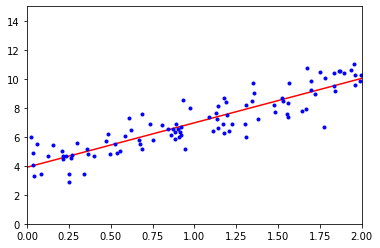

In [7]:
from matplotlib import pyplot as plt
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

### 4.1.2 scikit learn을 활용한 선형회귀 수행

In [8]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.8994799]), array([[3.06644582]]))

In [9]:
lin_reg.predict(X_new)

array([[ 3.8994799 ],
       [10.03237153]])

LinearRegression 클래스는 scipy.linalg.listq()함수를 기반으로 함. 이 함수를 직접 호출하는 것도 가능.

In [10]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.8994799 ],
       [3.06644582]])

위 함수는 유사역행렬(의사역행렬)을 활용하여 파라메타를 계산함. np.linalg.pinv()를 사용하여 유사역행렬을 직접 구할 수도 있음.  
유사 역행렬: A_+ = (A_T*A)^-1*A_T


In [11]:
np.linalg.pinv(X_b).dot(y)

array([[3.8994799 ],
       [3.06644582]])

유사역행렬 자체는 특잇값 분해(SVD, singular value decomposition)을 사용해 계산됨.  
정규방정식을 계산하는 것보다 이 방식이 훨씬 효율적이며 극단적인 경우도 처리할 수 있음.

## 4.2 경사하강법